<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/BlackPlague-SIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy
import scipy.stats
import scipy.integrate
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import jit
from matplotlib import cm
import emcee
import pystan
import time
import pytwalk as twalk

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [0]:

def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

Text(0.5, 1.0, 'Cumulative deaths Elyam, UK 1666')

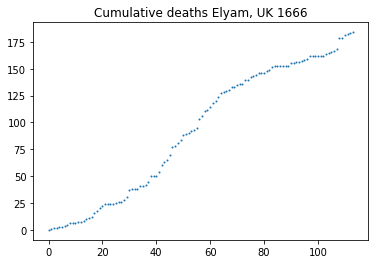

In [7]:

''' Second black plague outbreak in Elyam, UK 
    June 19, 1666 to Nov 1, 1666 (Massel et al 2004)
    114 days
    The village had been quarantined so the population
    is fixed to N=261. 
    
    States: 
        S(t): susceptible
        I(t): infected
        R(t): removed
        N=S(t)+I(t)+R(t)
    obs: once you get the plague you never recover, you die 
    
    '''
    
N=261 #Total population   

def SIR( X, t,  alpha, beta, I0  ):
    dSdt= -beta* X[0] * X[1]
    dIdt= beta*X[0] * X[1]- alpha*X[1]
    dRdt= alpha*X[1]
    return np.array( [   dSdt, dIdt, dRdt   ]   )
    

data = pd.read_csv("Eyam_time_SIR.csv") 
data.index
y=np.append(0, pd.Series.to_numpy(data.iloc[:, 3])) #cumulative deaths 
x=pd.Series.to_numpy(data.iloc[ 111:114 , 2 ])
n=len(y)        
ts=np.arange(0,len(y),1 )


plt.scatter( ts,y, s=1)
plt.title('Cumulative deaths Elyam, UK 1666')


In [0]:

def logprior( Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=N  ):
         a= -alpha-beta+I0*np.log( 5/N )+(N-I0)*np.log( 1- 5/N   )
         b=scipy.special.loggamma(N+1)- scipy.special.loggamma(I0+1)- scipy.special.loggamma(N-I0+1)
         return a+b
    else:
         return -np.inf
    
    
def logL(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    n=len(y)
    X0=np.array( [N-I0, I0, 0] )
    Xt = odeint( SIR, X0, ts, args=(alpha,beta,I0,))  
    It= Xt[:,1]
    It[It<0]=0
    Rt=Xt[:,2]
    Rt[Rt>261]=261
    ll=0
    ll=ll+np.log( It[n-2]/N +1e-300 )+(N-1)*np.log( 1- It[n-2]/N    )+N*np.log( 1- It[n-1]/N  )
    ll=ll+ np.sum(y[1:n]* np.log( Rt[1:] /N ))+np.sum( (N-y[1:])  *np.log(   1- Rt[1:]/N +1e-300 ))
    return ll
    

def lpost(Theta): #energy function
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=N  ):
         return -logprior(Theta)-logL(Theta) 
    else:
         return np.inf
  

def fpoints(f, args, theta,  pars , lb, upb, m=100):
    '''f is the objective function to be plotted
       args are the arguments of f as a list
       theta is the vector of true parameters
       pars are the parameters to be plotted (passed as an array)
       lb: array of lower bounds
       upb:array of upper bounds
       '''
       
    xx = np.linspace(lb[0], upb[0], m)
    yy = np.linspace(lb[1], upb[1], m)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(shape=[m, m])
    mask = np.zeros( theta.shape, dtype=bool )
    mask[pars] = True
    temp=np.zeros(theta.shape)
    for i in range( m ):
        for j in range( m ):
            temp[mask]=np.array( [xx[i][j], yy[i][j]] )
            temp[~mask]= theta[~mask]
            #Z[i][j] = f( temp , args)
            Z[i][j] = f( temp )
    return xx,yy,Z 

def pContour(xx,yy,Z,c=100):
    plt.contour( xx, yy, Z, c, colors='b' )
    plt.xlabel( r'$\theta_1$' )
    plt.ylabel( r'$\theta_2$' )
    plt.title( r'Objective Function Contours' )
    plt.show()

def pSurface(xx,yy, Z):
    fig = plt.figure()
    ax = plt.axes( projection='3d' )
    ax.plot_surface( xx, yy, Z, cmap='Spectral')
    # ax.contour3D(xx, yy, Z, 30, cmap='binary')
    ax.set_xlabel( r'$\theta_1$' )
    ax.set_ylabel( r'$\theta_2$' )
    ax.set_zlabel( r'$Posterior Surface' )
    ax.view_init( 60, 35 )
    fig






In [48]:
#Critical points 
from scipy import optimize

a=scipy.stats.uniform.rvs( 0.085, 0.12-0.085, 1  )
b=scipy.stats.uniform.rvs( 0.0004, 0.00075-0.0004, 1  )

xopt=optimize.minimize( lpost ,  np.array([a[0],b[0],5 ])  ,method='bfgs', tol=1e-5)
xopt['x']


array([1.03974221e-01, 6.94544193e-04, 5.00000000e+00])

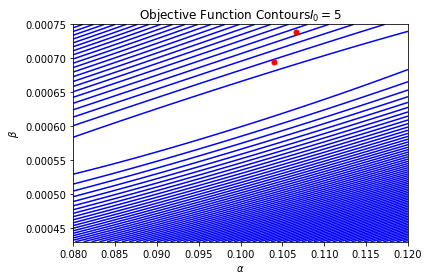

In [49]:
#Maximum points and contour function

xx,yy,Z= fpoints(f= lpost,args=1, theta= np.array([ 0.09 , 0.0007 , 5 ]) ,
                  pars= np.array([ 0,1]),
                  lb=np.array([ 0.080, 0.00043 ])  , upb= np.array([ .120 , 0.00075  ])  , m=100 )

#xopt1=np.array([1.03235218e-01, 6.54904342e-04, 4.30228503e+00])
xopt1=np.array([1.03974221e-01, 6.94544193e-04, 5.00000000e+00])
xopt2=np.array([1.06568129e-01, 7.38785972e-04, 5.00000000e+00])

plt.plot( xopt1[0],xopt1[1] ,'.' , markersize=10 , color='red')
plt.plot( xopt2[0],xopt2[1] , '.' , markersize=10 , color='red')
plt.contour( xx, yy, Z, 100, colors='b' )
plt.xlabel( r'$\alpha$')
plt.ylabel( r'$\beta$' )
plt.title( r'Objective Function Contours'+r'$I_0=5$' )
plt.show()

In [0]:
#----------------------- t-walk

def p0(): #prior function for the t walk
    a=scipy.stats.uniform.rvs(0, 0.0008 , 1)
    b= scipy.stats.uniform.rvs(0, 0.0008 , 1)
    c=scipy.stats.uniform.rvs(1,7, 1)
   
    return np.array([a[0],b[0],c[0]])


def supp(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=7 and alpha<1 and beta<1  ):
         return True
    else:
        return False



In [63]:

T=1000000 #number of iterations
#x0= np.array([1.11528561e-01, 7.42622491e-04, 5.00000000e+00])
#xp0=np.array([1.03351566e-01, 6.55532405e-04, 4.29146012e+00])
x0=p0()
xp0=p0()

tchain = twalk.pytwalk( n=3, U=lpost, Supp=supp )
tchain.Run( T=T , x0= x0 , xp0=xp0)



pytwalk: Running the twalk with 1000000 iterations .  Mon, 15 Jun 2020, 01:20:38.
       Finish by Mon, 15 Jun 2020, 01:52.


/content/pytwalk.py:316: RuntimeWarning: overflow encountered in exp
  A = exp(u - u_prop)
/content/pytwalk.py:358: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) +  (self.nphi-2)*log(beta))
/content/pytwalk.py:302: RuntimeWarning: overflow encountered in exp
  A = exp(up - up_prop)
/content/pytwalk.py:341: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) +  (self.nphi-2)*log(beta))


pytwalk:      32768 iterations so far. Finish by Mon, 15 Jun 2020, 01:36.
pytwalk:      98304 iterations so far. Finish by Mon, 15 Jun 2020, 01:36.
pytwalk:     229376 iterations so far. Finish by Mon, 15 Jun 2020, 01:36.
pytwalk:     491520 iterations so far. Finish by Mon, 15 Jun 2020, 01:35.
pytwalk: finished, Mon, 15 Jun 2020, 01:35:55.


1

Acceptance rates for the Walk, Traverse, Blow and Hop kernels:[3.42980428e-01 1.24977354e-01 6.05877007e-05 0.00000000e+00]
Global acceptance rate: 0.23023
AutoMaxlag: maxlag= 1030.
Integrated Autocorrelation Time:    52.2, IAT/n:    17.4
AutoMaxlag: maxlag= 1030.
(850001, 3)


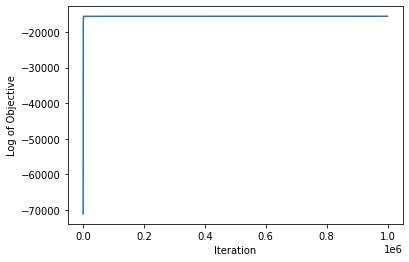

In [68]:

tchain.Ana()
tchain.IAT()
bi=int(0.15*T)
toutput=tchain.Output[bi:, 0:3 ]
print(toutput.shape)


In [69]:
Analysis(toutput)

{'Mean': array([1.34559695e-02, 7.99145272e-04, 6.83566221e+00]),
 'Median': array([1.34489478e-02, 7.98315734e-04, 6.88109111e+00]),
 'Variance': array([7.95933150e-08, 8.92813110e-10, 2.42202222e-02]),
 'ess': array([7156.22193082, 6260.7137764 , 4648.12298686]),
 'mVar': array([1.11222536e-11, 1.42605642e-13, 5.21075330e-06]),
 'mess': 4648.122986857698}

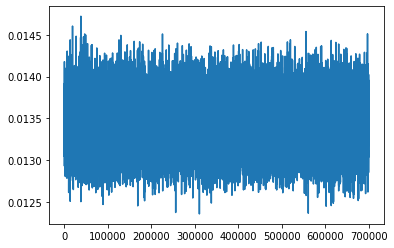

In [70]:
plt.plot( toutput[ bi :,0])

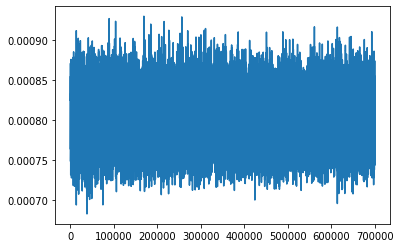

In [71]:
plt.plot( toutput[ bi :,1])

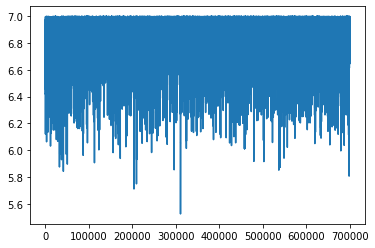

In [72]:
plt.plot( toutput[ bi :,2])

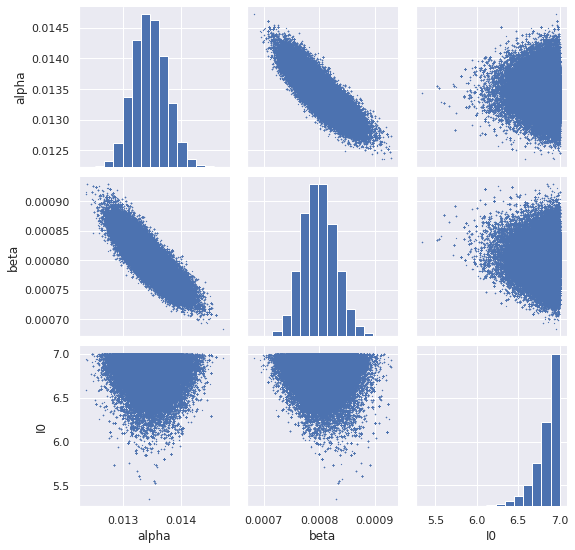

In [76]:

d = {'alpha': toutput[:,0], 'beta': toutput[:,1], 'I0': toutput[:,2] }
tresults= pd.DataFrame(data=d)

sns.set()
sns.pairplot(tresults, markers='.', plot_kws=dict(s=1, edgecolor="b"),diag_kws=dict(bins=15) )



In [0]:

def predobs( alpha, beta, I0s, tup=136  ,sample_size=150 ):
    L=len(alpha)
    obs=np.zeros([ sample_size  , tup]) 
    
    SSts=np.zeros([ sample_size  , tup]) 
    IIts=np.zeros([ sample_size  , tup]) 
    RRts=np.zeros([ sample_size  , tup]) 
    
    ts=np.arange(0,tup, 1)
    
    #sample of size sample_size of betas and I0s. 
    #which observations to take into account for the predictive
    indexes=np.random.choice(a = np.arange( 0, L )   , size = sample_size, replace = False)
    
    salphas=alpha[indexes]
    sI0s= I0s[indexes]
    sbetas= beta[indexes]
    for i in range(sample_size ):
        X0=np.array( [N-I0s[i], I0s[i], 0] )
        Xt=scipy.integrate.odeint( SIR, X0, ts, args=(salphas[i],sbetas[i],sI0s[i],) ) 
        It=Xt[:,1]
        It[It<0]=0
        Rt=Xt[:,2]
        Rt[Rt>261]=261
        
        SSts[i]=Xt[ :,0]
        IIts[i]=Xt[ :,1]
        RRts[i]=Xt[ :,2]
        obs[i]=scipy.stats.binom.rvs( n=N, p= Rt/N )
        
    return SSts, IIts, RRts,  obs
        
        



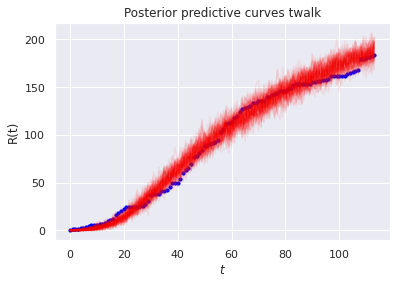

In [105]:

  
#### Predictive distribution

SSts, IIts, RRts,  obspred=predobs( toutput[:,0] , toutput[:,1] , toutput[:,2]   , tup=114, sample_size=300)

indexes=np.random.choice(a = np.arange( 0,  obspred.shape[0] ), size =100, replace = False)
obs_samples=obspred[indexes]

SSts_samples=SSts[indexes]
IIts_samples=IIts[indexes]

for i in range( len(obs_samples )  ):
    plt.plot(obs_samples[i], color='red' , alpha=0.07 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Posterior predictive curves twalk' )
plt.savefig( 'twalkRtBlackPlague.pdf', dpi=500  )
plt.show()



In [0]:
# ------------------------------- emcee


def post_emcee(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=10 and alpha<1 and beta<1  ):
         return logprior(Theta)+logL(Theta) 
    else:
         return -np.inf
    

def p0_emcee(nwalkers=1):
    p0=np.zeros([nwalkers,3])
    a=scipy.stats.uniform.rvs(0, 1, nwalkers)
    b= scipy.stats.uniform.rvs(0, 1 , nwalkers)
    c=scipy.stats.uniform.rvs(1,9, nwalkers)
    p0[:,0]=a
    p0[:,1]=b
    p0[:,2]=c
    return p0


In [83]:

import os

os.environ["OMP_NUM_THREADS"] = "4"

from multiprocessing import Pool
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

2 CPUs


In [88]:

nwalkers = 10
T=50000
bi=int(0.10*T)
p0=p0_emcee(nwalkers)
ndim=p0.shape[1]


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, post_emcee, pool=pool)
    sampler.run_mcmc(p0, T, progress=True)
    

100%|██████████| 50000/50000 [09:43<00:00, 85.65it/s]


In [0]:

samples = sampler.get_chain( flat=True)


emcee_chains = sampler.get_chain(discard=bi)


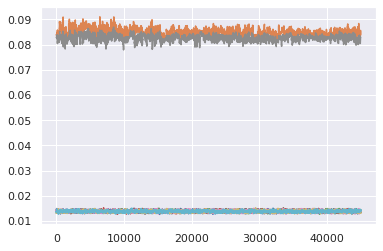

In [90]:



plt.plot(emcee_chains[:,0,0 ])
plt.plot(emcee_chains[:,1,0 ])
plt.plot(emcee_chains[:,2,0 ])
plt.plot(emcee_chains[:,3,0 ])
plt.plot(emcee_chains[:,4,0 ])
plt.plot(emcee_chains[:,5,0 ])
plt.plot(emcee_chains[:,6,0 ])
plt.plot(emcee_chains[:,7,0 ])
plt.plot(emcee_chains[:,8,0 ])
plt.plot(emcee_chains[:,9,0 ])



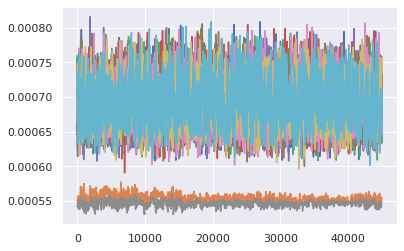

In [91]:
plt.plot(emcee_chains[:,0,1 ])
plt.plot(emcee_chains[:,1,1 ])
plt.plot(emcee_chains[:,2,1 ])
plt.plot(emcee_chains[:,3,1 ])
plt.plot(emcee_chains[:,4,1 ])
plt.plot(emcee_chains[:,5,1 ])
plt.plot(emcee_chains[:,6,1 ])
plt.plot(emcee_chains[:,7,1 ])
plt.plot(emcee_chains[:,8,1 ])
plt.plot(emcee_chains[:,9,1 ])

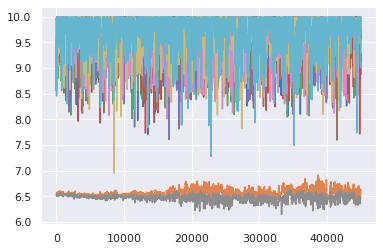

In [92]:
plt.plot(emcee_chains[:,0,2 ])
plt.plot(emcee_chains[:,1,2 ])
plt.plot(emcee_chains[:,2,2 ])
plt.plot(emcee_chains[:,3,2 ])
plt.plot(emcee_chains[:,4,2 ])
plt.plot(emcee_chains[:,5,2 ])
plt.plot(emcee_chains[:,6,2 ])
plt.plot(emcee_chains[:,7,2 ])
plt.plot(emcee_chains[:,8,2 ])
plt.plot(emcee_chains[:,9,2 ])

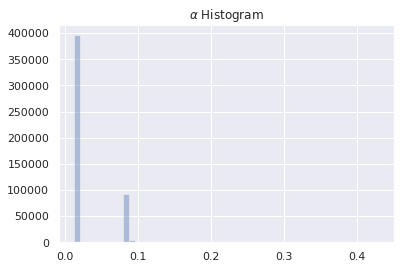

In [116]:



sns.distplot( samples[bi:,0] , kde=False)
plt.title(r'$\alpha$'+' Histogram')
plt.savefig('emceealpha.png', dpi=500)


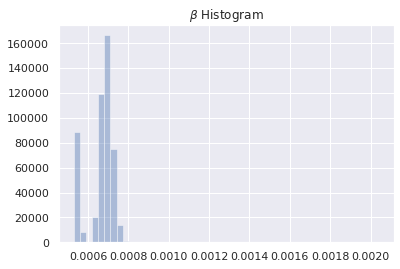

In [117]:
sns.distplot( samples[bi:,1] , kde=False )
plt.title(r'$\beta$'+' Histogram')
plt.savefig('emceebeta.png', dpi=500)


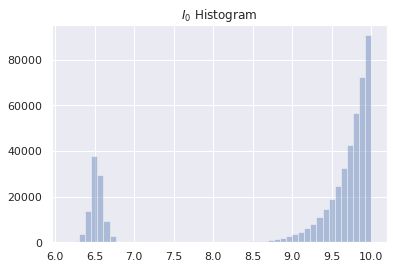

In [118]:
sns.distplot( samples[bi:,2], kde=False )
plt.title(r'$I_0$'+' Histogram')
plt.savefig('emceeI_0.png', dpi=500)

In [102]:
Analysis(samples[bi:])

{'Mean': array([2.88833961e-02, 6.68057172e-04, 9.09060215e+00]),
 'Median': array([1.38928260e-02, 6.82524659e-04, 9.72164886e+00]),
 'Variance': array([1.20021301e-03, 8.38119381e-09, 1.67210442e+00]),
 'ess': array([797382.65311278, 567768.56292012, 936932.21890944]),
 'mVar': array([1.50519078e-09, 1.47616377e-14, 1.78465889e-06]),
 'mess': 567768.5629201218}

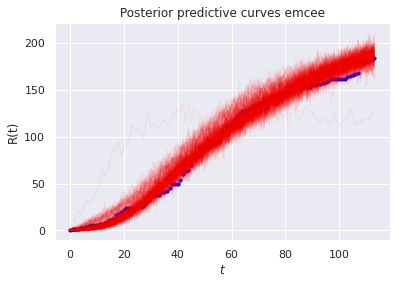

In [115]:
#### Predictive distribution

SSts, IIts, RRts,  obspred=predobs( samples[bi:,0] , samples[bi:,1] , samples[bi:,2]   , tup=114, sample_size=300)

indexes=np.random.choice(a = np.arange( 0,  obspred.shape[0] ), size =250, replace = False)
obs_samples=obspred[indexes]

SSts_samples=SSts[indexes]
IIts_samples=IIts[indexes]

for i in range( len(obs_samples )  ):
    plt.plot(obs_samples[i], color='red' , alpha=0.05 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Posterior predictive curves emcee' )
plt.savefig( 'emceeRtBlackPlague.pdf', dpi=500  )
plt.show()


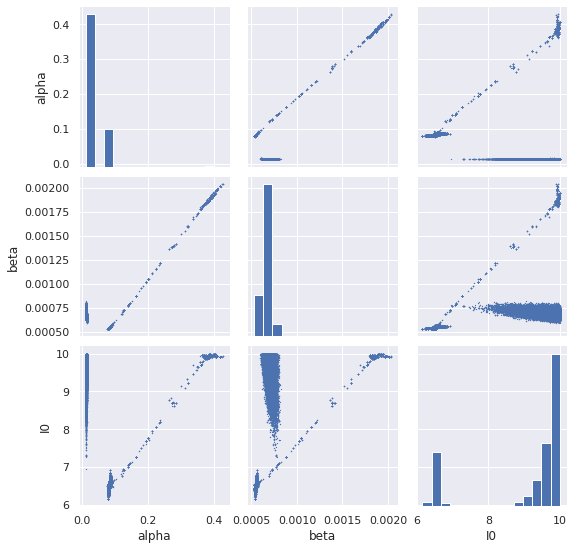

In [108]:
d = {'alpha': samples[bi:,0], 'beta': samples[bi:,1], 'I0': samples[bi:,2] }
tresults= pd.DataFrame(data=d)

sns.set()
sns.pairplot(tresults, markers='.', plot_kws=dict(s=1, edgecolor="b"),diag_kws=dict(bins=15) )
plt.savefig('emceepairplot.png', dpi=500)

In [122]:
Analysis(samples)


{'Mean': array([3.00825826e-02, 1.70065891e-03, 9.06288416e+00]),
 'Median': array([1.38911203e-02, 6.82931109e-04, 9.71858208e+00]),
 'Variance': array([1.90895552e-03, 4.20451112e-04, 1.81605370e+00]),
 'ess': array([5.33941400e+05, 3.92509883e+02, 6.99103231e+05]),
 'mVar': array([3.57521540e-09, 1.07118605e-06, 2.59769032e-06]),
 'mess': 392.50988311749717}

In [123]:
samples.shape

(500000, 3)